In [0]:
from loaddata import *
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
pd.set_option('display.width', 1000)

In [5]:
# Load scenario 10 data
df = load_data('datasets/capture20110818.pcap.netflow.labeled')
# Remove background flows
df = df.loc[df['Label'] != 'Background']
# Reset index
df.reset_index(drop=True)
df.head()

,Date_flow,start,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,src_ip,src_port,dst_ip,dst_port
20,2011-08-18,10:19:13.347,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949
51,2011-08-18,10:19:13.392,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443
57,2011-08-18,10:19:13.411,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80
73,2011-08-18,10:19:13.460,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80
75,2011-08-18,10:19:13.486,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443


---------- Netflows from infected hosts statistics----------
              Durat      Tos       Packets          Bytes    Flows
count  19889.000000  19889.0  19889.000000   19889.000000  19889.0
mean       0.551279      0.0     15.838705   14104.124943      1.0
std        1.436274      0.0    102.152312   84291.197116      0.0
min        0.000000      0.0      1.000000      60.000000      1.0
25%        0.000000      0.0      1.000000    1066.000000      1.0
50%        0.000000      0.0      1.000000    1066.000000      1.0
75%        0.000000      0.0      1.000000    1066.000000      1.0
max        4.999000      0.0   1000.000000  787188.000000      1.0
---------- Netflows from normal hosts statistics ----------
              Durat      Tos       Packets         Bytes    Flows
count  39925.000000  39925.0  39925.000000  3.992500e+04  39925.0
mean       0.356154      0.0     11.064596  8.127969e+03      1.0
std        1.045342      0.0    119.777720  1.236821e+05      0.0
min        0

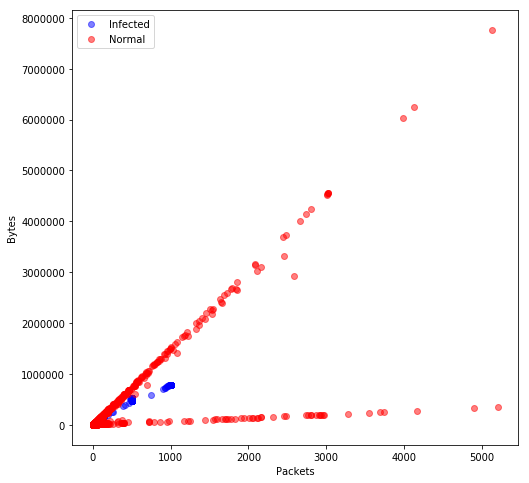

In [6]:
# Encode categorical features 
# labelencoder = LabelEncoder()
# df['Prot'] = labelencoder.fit_transform(df['Prot'])
# df['Flags'] = labelencoder.fit_transform(df['Flags'])

# Choose infected and normal hosts
infected_ip = '147.32.84.165'
normal_ip = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

# Separate infected and normal netflows
normal_df = df.loc[df['src_ip'].isin(normal_ip)]
infected_df = df.loc[df['src_ip'] == infected_ip]
normal_df.reset_index(drop=True)
infected_df.reset_index(drop=True)

print("---------- Netflows from infected hosts statistics----------")
print(infected_df.describe(include=[np.number]))
print("---------- Netflows from normal hosts statistics ----------")
print(normal_df.describe(include=[np.number]))

# Visualize features
plt.figure(figsize=(8,8))
plt.scatter(infected_df['Packets'], infected_df['Bytes'], c='blue', alpha=0.5, label='Infected')
plt.scatter(normal_df['Packets'], normal_df['Bytes'], c='red', alpha=0.5, label='Normal')
plt.xlabel("Packets")
plt.ylabel("Bytes")
# plt.boxplot(infected_df['Packets'])
plt.legend()
plt.show()


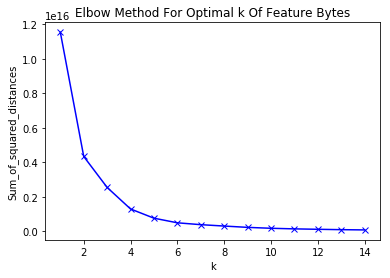

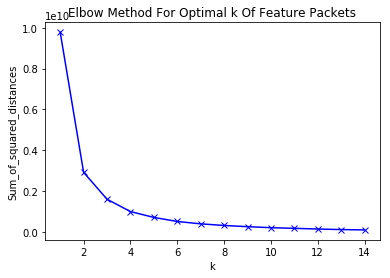

In [7]:
def elbow(feature):
  Sum_of_squared_distances = []
  K = range(1,15)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(df[feature].values.reshape(-1,1))
      center = km.cluster_centers_
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k Of Feature %s' % feature)
  plt.savefig('elbow_%s' % feature)
  plt.show()
  
elbow('Bytes')
elbow('Packets')

In [0]:
# Function to get values at n-th percentiles from the given feature
# e.g. bins = 5, will return 20 40 60 80 100th percentiles
def get_percentile_values(bins, feature):
  percentile = []

  # Copy data to a list and sort it
  values = df[feature].tolist()
  values.sort()

  for i in range(1, bins + 1):
    percent = int((((100/bins) * i)/100) * len(values))
    percentile.append(values[percent - 1])

  print("The percentile of Feature %s with %d bins is %s" % (feature, bins, percentile))
  return percentile

# Map a value to n-th percentile
def encode_percentile(value, percentile):
  length = len(percentile)
  code = length - 1
  
  for i in range(0, length):
    if(value <= percentile[i]):
      code = i
      break
  return code

def netflow_encoding(feature_values, bins_value):
  spaceSize = np.prod(bins_value)
  code = 0
  
  for i in range(len(bins_value)):
    code += feature_values[i] * spaceSize / bins_value[i]
    spaceSize /= bins_value[i]
  
  return code

In [11]:
df['Bytes_code'] = 0
bytes_bins = 6
percentile = get_percentile_values(bytes_bins, 'Bytes')
df['Bytes_code'] = df['Bytes'].apply(encode_percentile, args=[percentile])

df['Packets_code'] = 0
packets_bins = 8
percentile = get_percentile_values(packets_bins, 'Packets')
df['Packets_code'] = df['Packets'].apply(encode_percentile, args=[percentile])


The percentile of Feature Bytes with 6 bins is [120, 1066, 1066, 1066, 2132, 24972468]
The percentile of Feature Packets with 8 bins is [1, 1, 1, 1, 2, 4, 10, 16937]


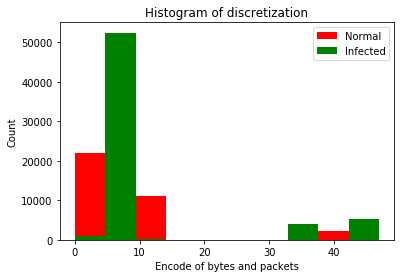

In [12]:
# Apply discretization to all hosts
discretize_df = df[['Bytes_code', 'Packets_code']]
result = discretize_df.apply(lambda x: netflow_encoding(x.tolist(), [bytes_bins, packets_bins]), axis = 1)

df['result'] = 0
df['result'] = result.values

# Separate flows from normal hosts and infected hosts
all_infected_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
infected_df = df.loc[df['src_ip'].isin(all_infected_ips)]
normal_df = df.loc[df['src_ip'].isin(normal_ip)]
normal_df.reset_index(drop=True)
infected_df.reset_index(drop=True)

# Visualize
plt.hist(normal_df['result'], color='r', label='Normal')
plt.hist(infected_df['result'], color='g', label='Infected')
plt.legend()
plt.gca().set(title='Histogram of discretization', xlabel='Encode of bytes and packets', ylabel='Count')
plt.show()